# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

In [ ]:
!nvidia-smi

Sun Mar 22 08:34:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# !pip install -qq arff2pandas

In [ ]:
# !pip install -q -U watermark

In [ ]:
# !pip install -qq -U pandas

In [ ]:
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,arff2pandas

CPython 3.6.9
IPython 5.5.0

numpy 1.18.2
pandas 1.0.3
torch 1.4.0
arff2pandas 1.0.1


In [2]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
# from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

By the end of this tutorial, you'll learn how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [ ]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
10.6MB [00:00, 40.1MB/s]


In [ ]:
!unzip -qq ECG5000.zip

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [3]:
# with open('data/ECG5000/ECG5000_TRAIN.arff') as f:
#   train = a2p.load(f)

# with open('data/ECG5000/ECG5000_TEST.arff') as f:
#   test = a2p.load(f)

In [41]:
train = pd.read_csv('data/ECG5000/ECG5000_TRAIN.txt', header=None, delim_whitespace=True)
train.columns = ['target'] + list(range(140))

In [33]:
test = pd.read_csv('data/ECG5000/ECG5000_TEST.txt', header=None, delim_whitespace=True)
test.columns = ['target'] + list(range(140))

We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [43]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [44]:
df.head()

,target,0,1,2,3,4,5,6,7,8,...,130,131,132,133,134,135,136,137,138,139
1577,1.0,-1.175840,-0.771456,-2.234445,-4.422567,-4.697272,-4.550699,-3.466229,-2.251740,-1.749851,...,-0.818689,-0.792321,-0.550280,0.317041,0.755046,0.547730,0.482171,-0.324413,0.050543,0.660399
2532,1.0,1.055882,0.324238,-1.221153,-2.221034,-3.146072,-3.430421,-2.804038,-1.952079,-1.655294,...,0.387576,0.841028,1.086623,0.748508,0.715252,0.389908,0.249023,0.318490,0.861723,1.355128
3464,2.0,-0.919906,-1.435172,-1.700165,-1.817940,-2.053490,-2.185987,-2.068212,-1.832662,-1.199622,...,-0.345754,-1.096569,-1.891550,-2.774862,-3.834836,-4.556208,-4.364823,-3.393180,-2.406815,-1.965159
1382,1.0,0.837342,-1.566331,-3.168719,-4.069600,-4.920173,-4.476308,-2.863320,-1.844990,-1.627832,...,0.206437,1.138322,1.927484,1.793192,1.964867,1.611894,1.161988,0.205990,-0.487169,0.107766
1219,1.0,0.243254,-2.559384,-3.294061,-3.500945,-3.045317,-2.368781,-0.994040,-0.303798,-0.019706,...,-0.623922,-0.539454,-0.593563,-0.803710,-0.788719,-0.988701,-0.769639,-0.730476,-1.425795,-4.165895


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [45]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [40]:
# new_columns = list(df.columns)
# new_columns[-1] = 'target'
# df.columns = new_columns

TypeError: Index does not support mutable operations

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [46]:
df.target.value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: target, dtype: int64

Let's plot the results:

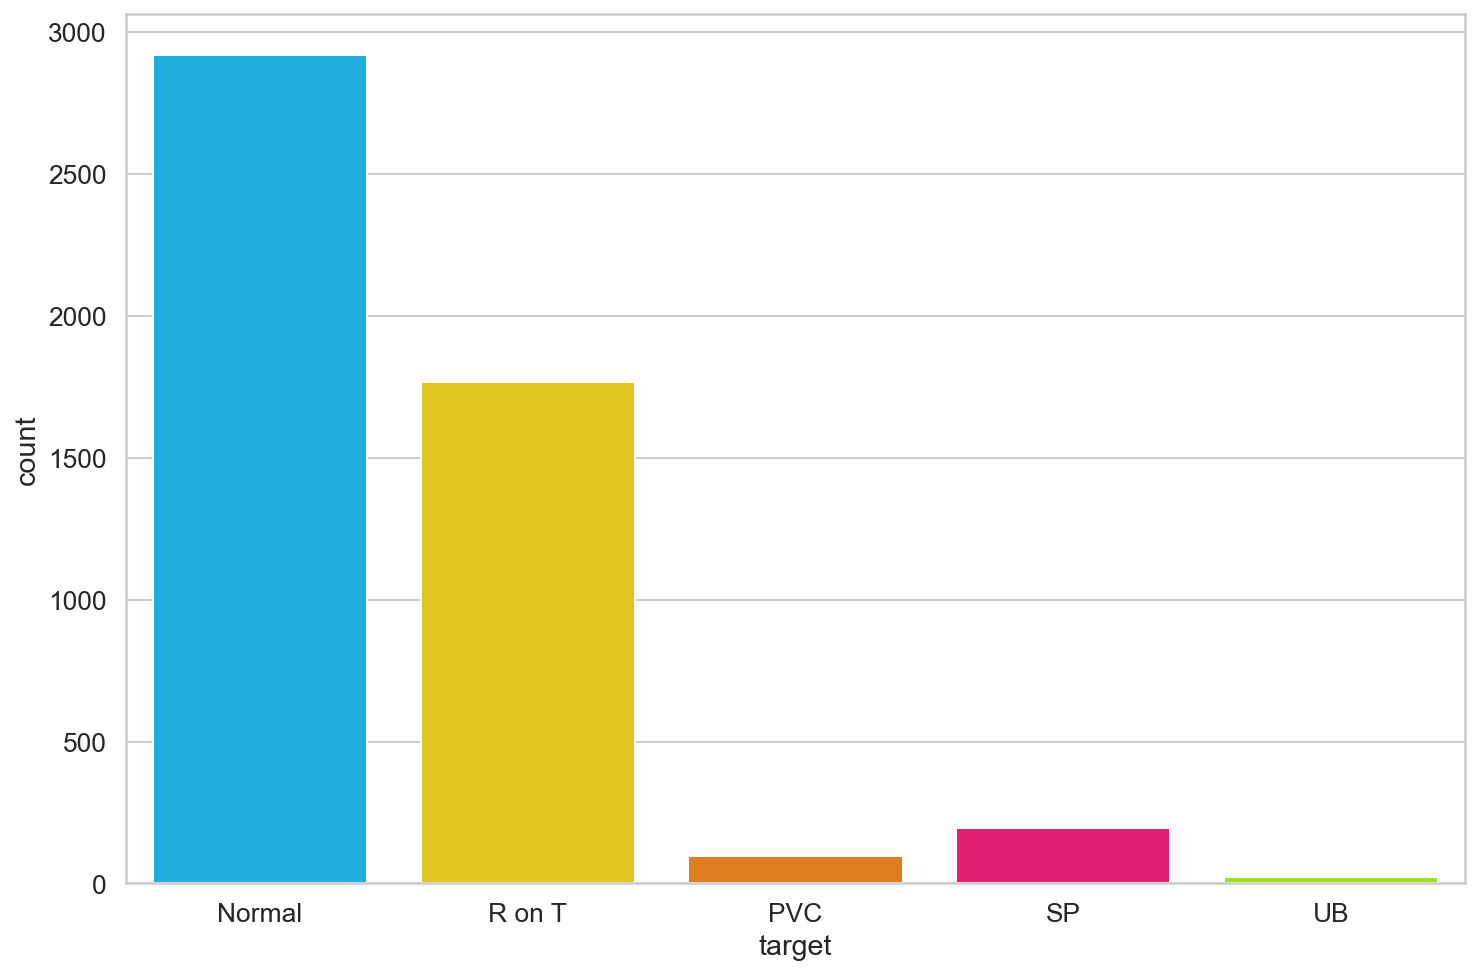

In [52]:
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [53]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

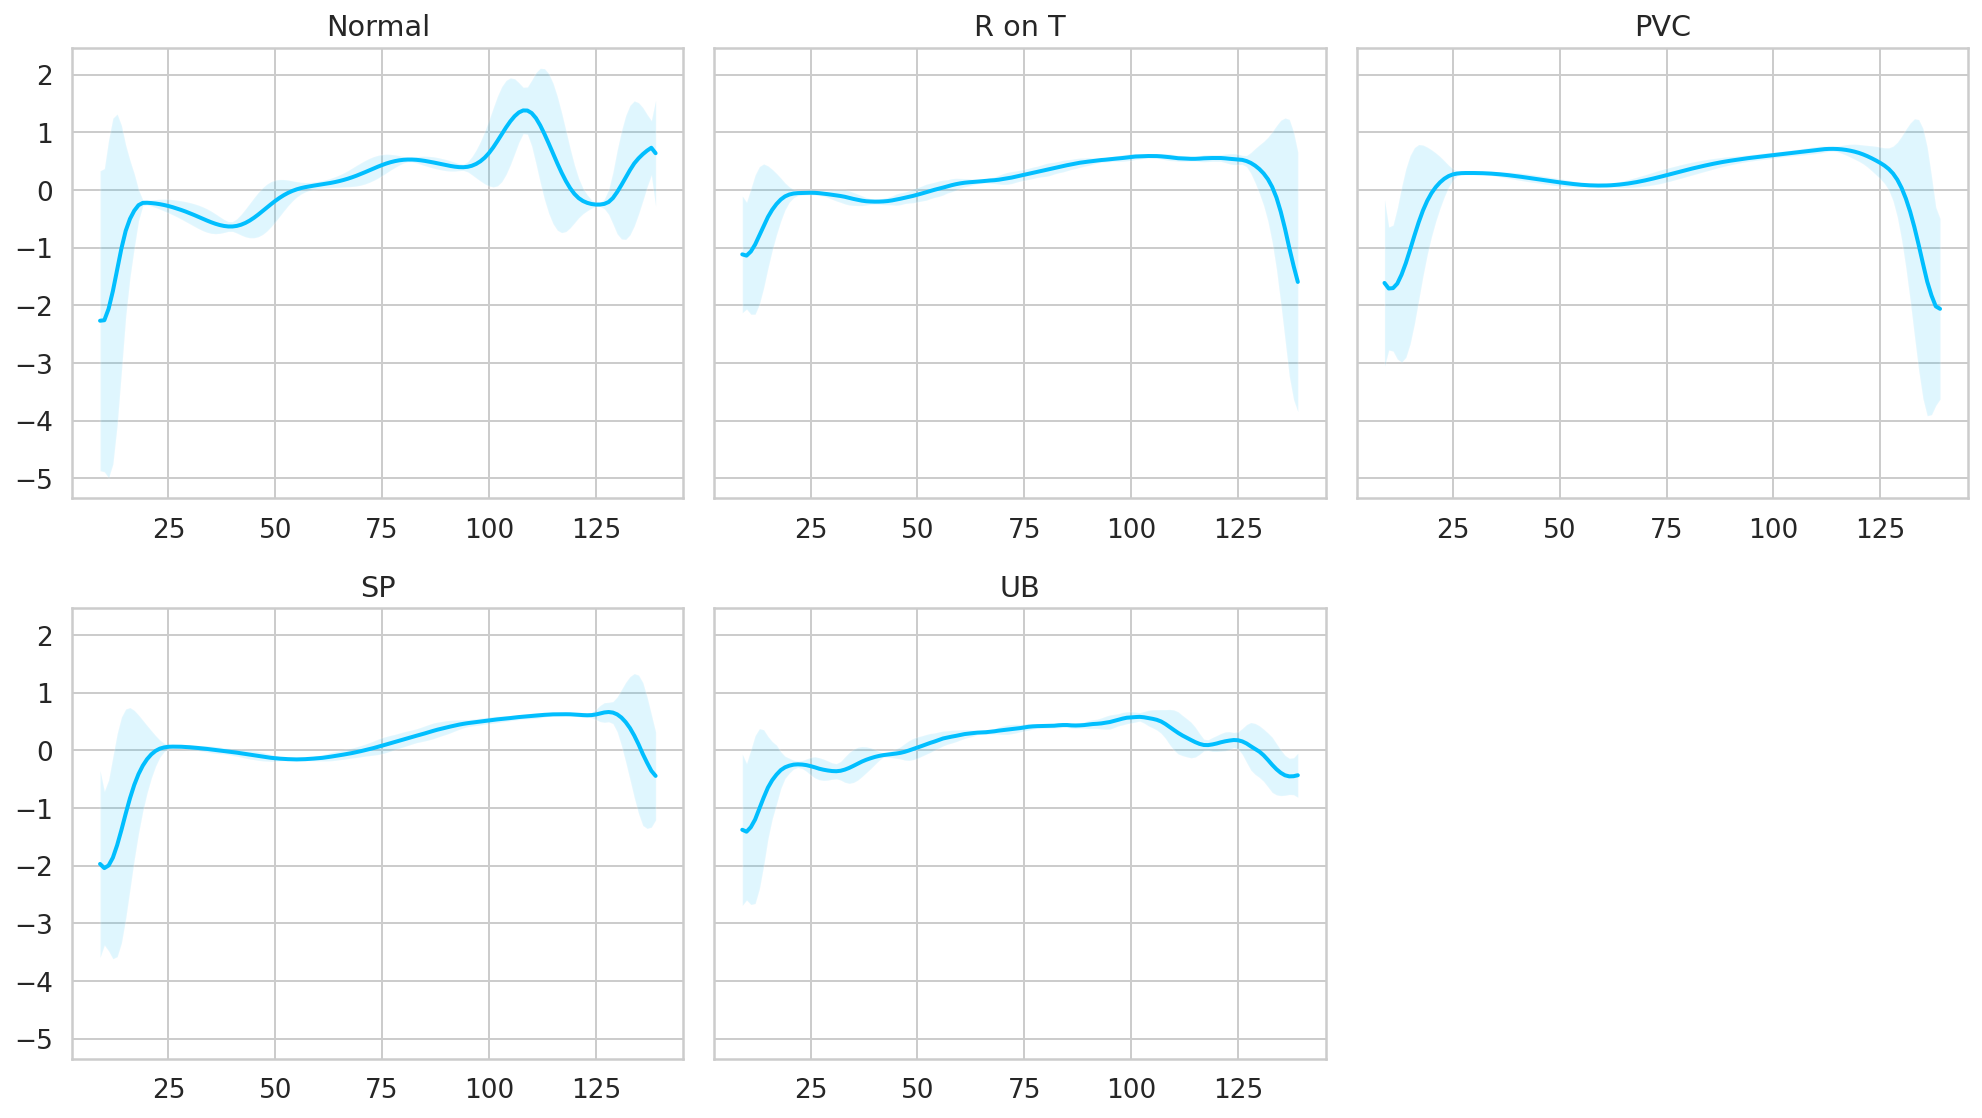

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [57]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

We'll merge all other classes and mark them as anomalies:

In [59]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

We'll split the normal examples into train, validation and test sets:

In [60]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [61]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [62]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [63]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [64]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [65]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [68]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

Let's write a helper function for our training process:

In [69]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [72]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=10 #150
)

Epoch 1: train loss 21.691360373691126 val loss 21.74888937627903
Epoch 2: train loss 21.059943545494097 val loss 23.235180395861942
Epoch 3: train loss 20.961633874062134 val loss 23.837261300851868
Epoch 4: train loss 20.51100474122742 val loss 19.61423185172748
Epoch 5: train loss 19.94963265983677 val loss 17.817369207180402
Epoch 6: train loss 19.617471548108888 val loss 18.27889571336349
Epoch 7: train loss 19.643763636735503 val loss 18.328536411194264
Epoch 8: train loss 18.81866052851279 val loss 22.497011409277803
Epoch 9: train loss 18.95093987306151 val loss 18.158737416967192
Epoch 10: train loss 17.9801740140888 val loss 17.516441123884285


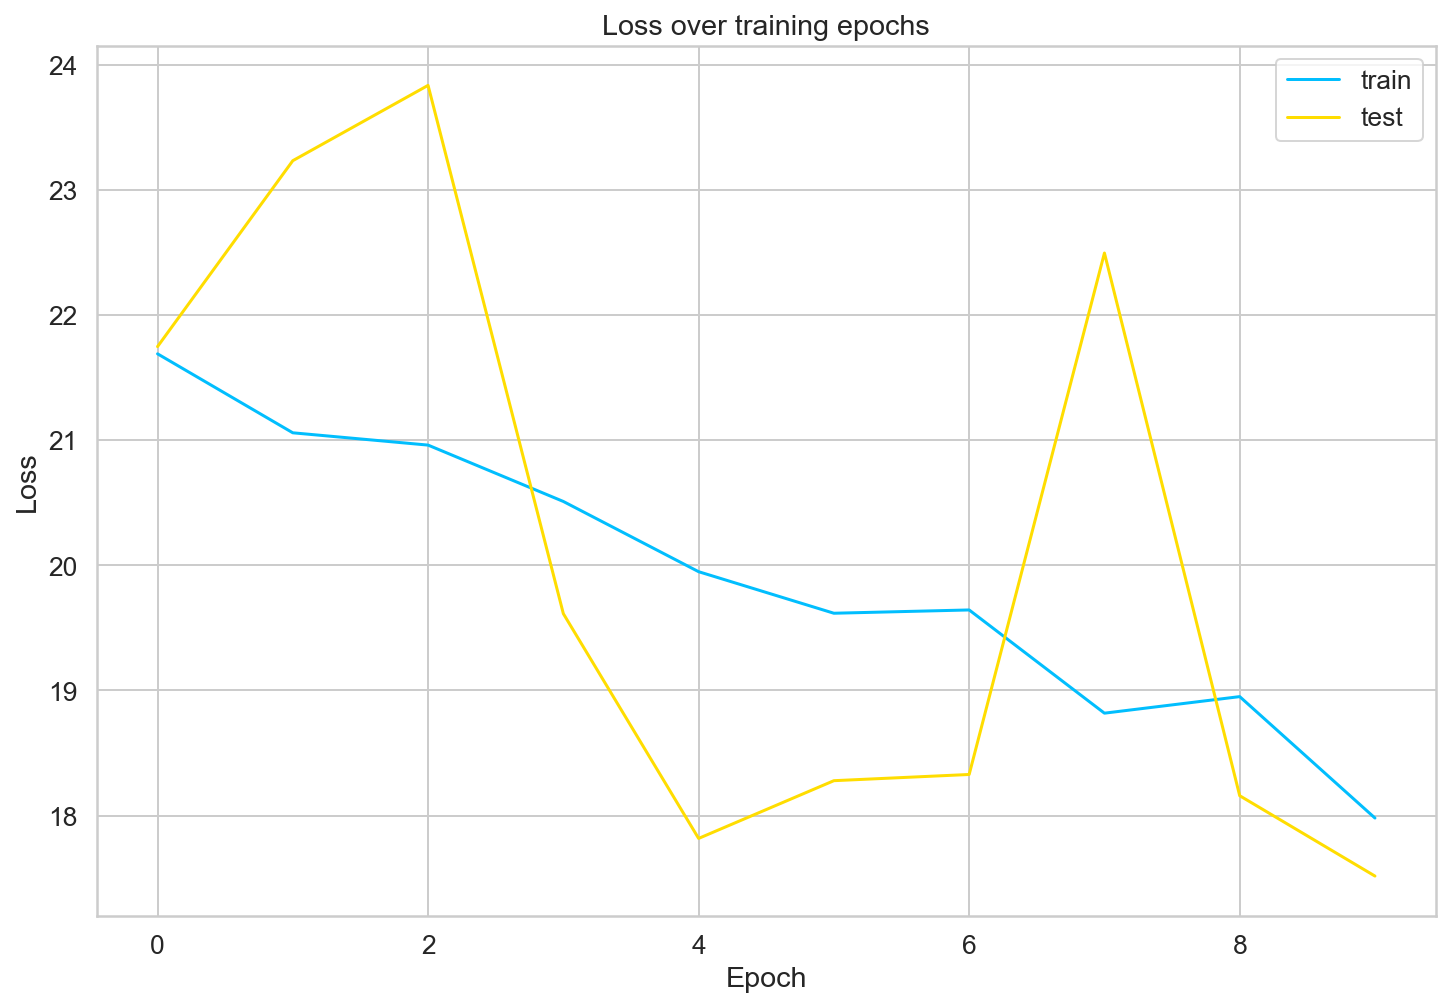

In [73]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [74]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [ ]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [75]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

C:\Users\M\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


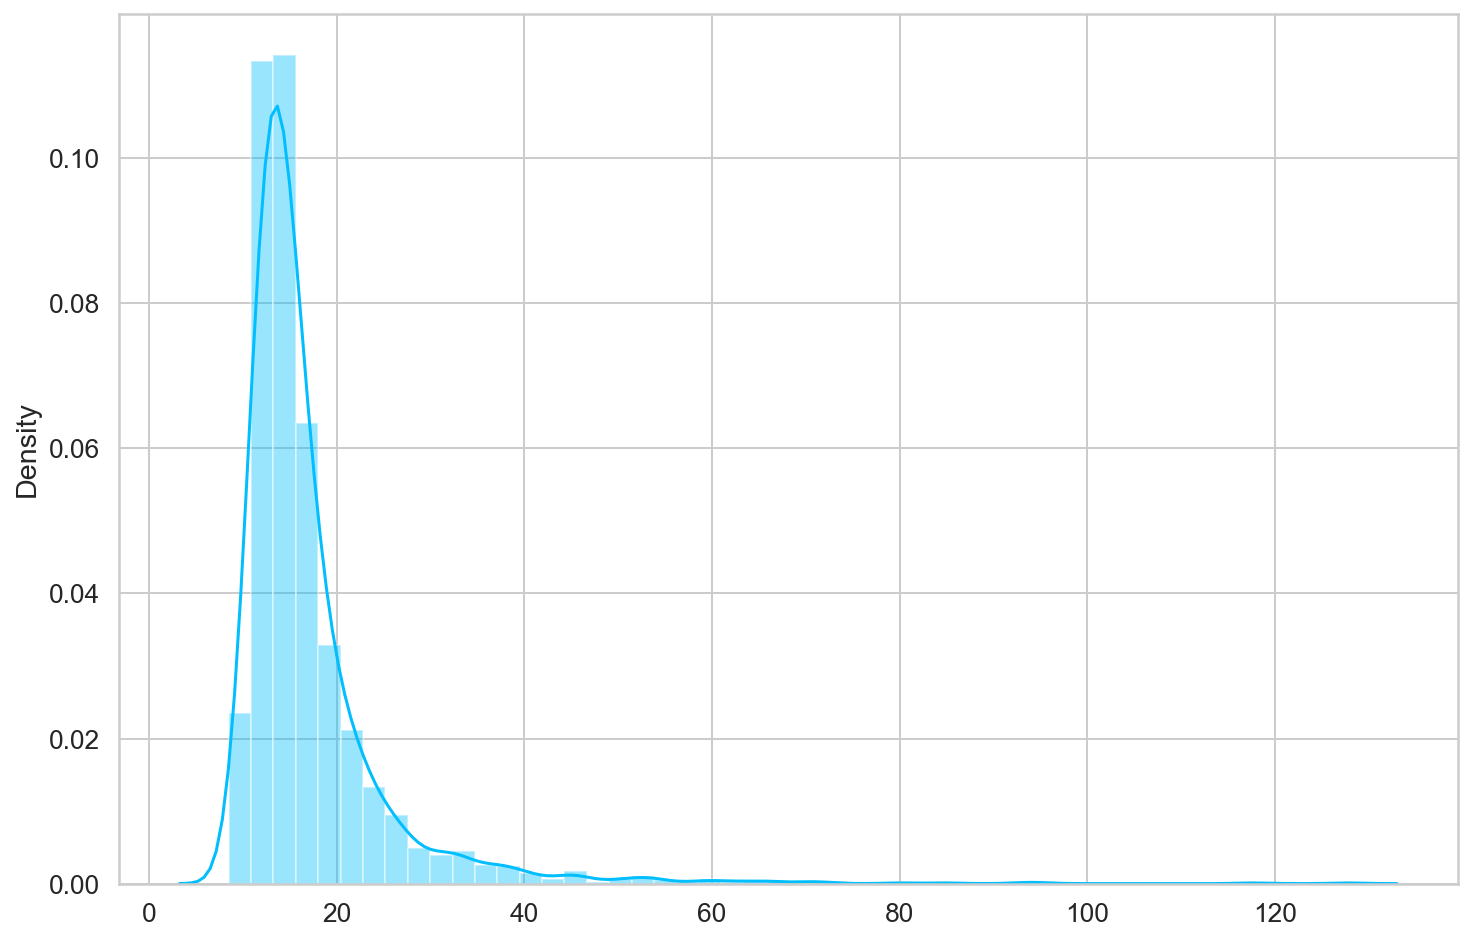

In [76]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [77]:
THRESHOLD = 26

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

C:\Users\M\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


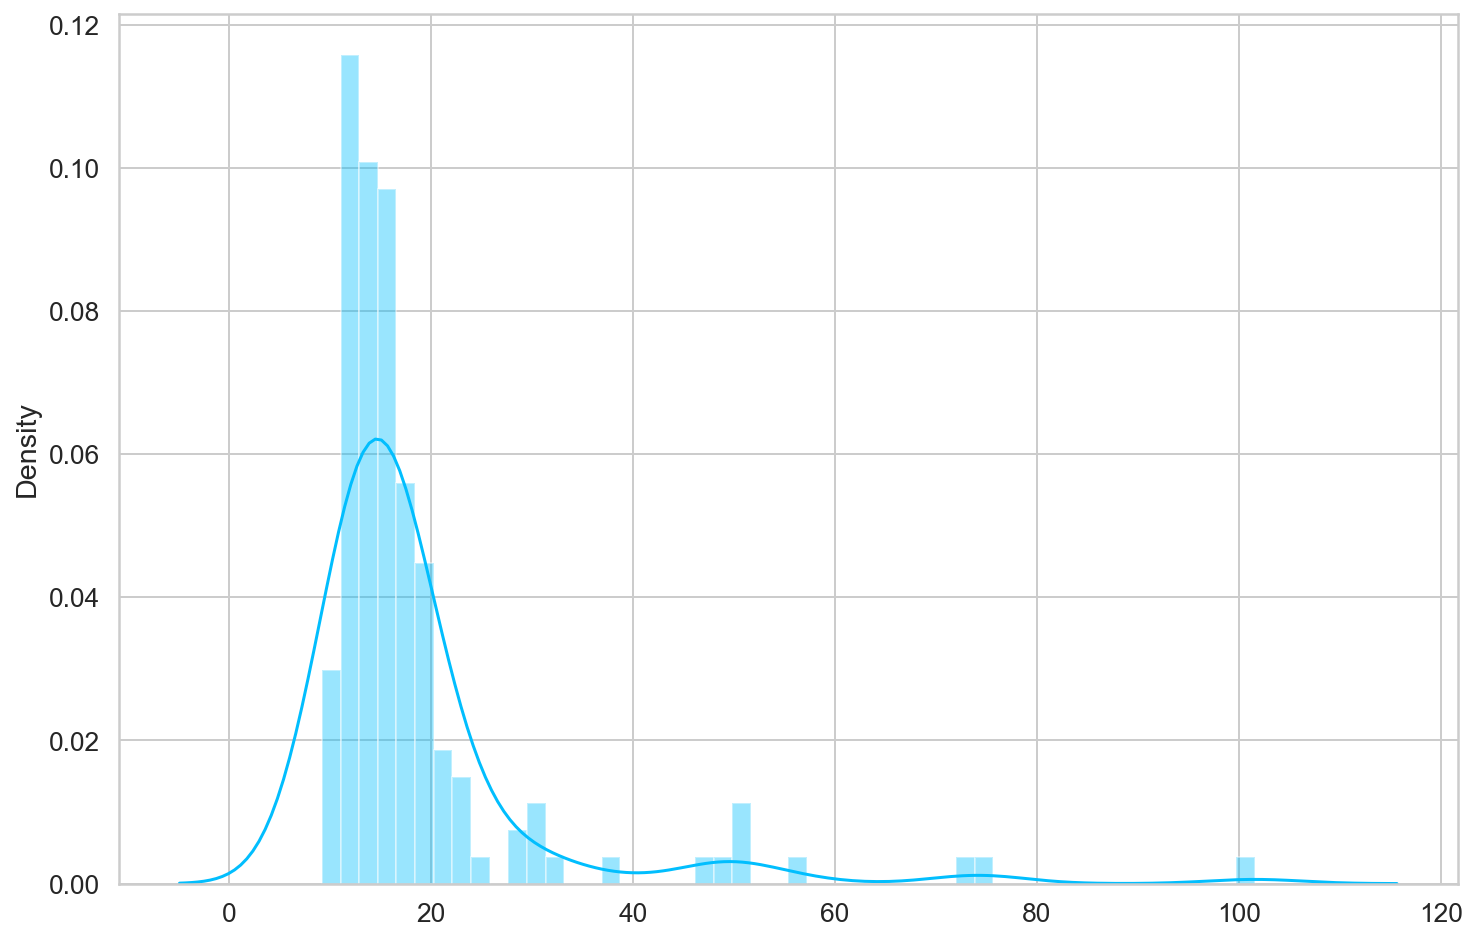

In [78]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [79]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 129/145


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [80]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

C:\Users\M\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


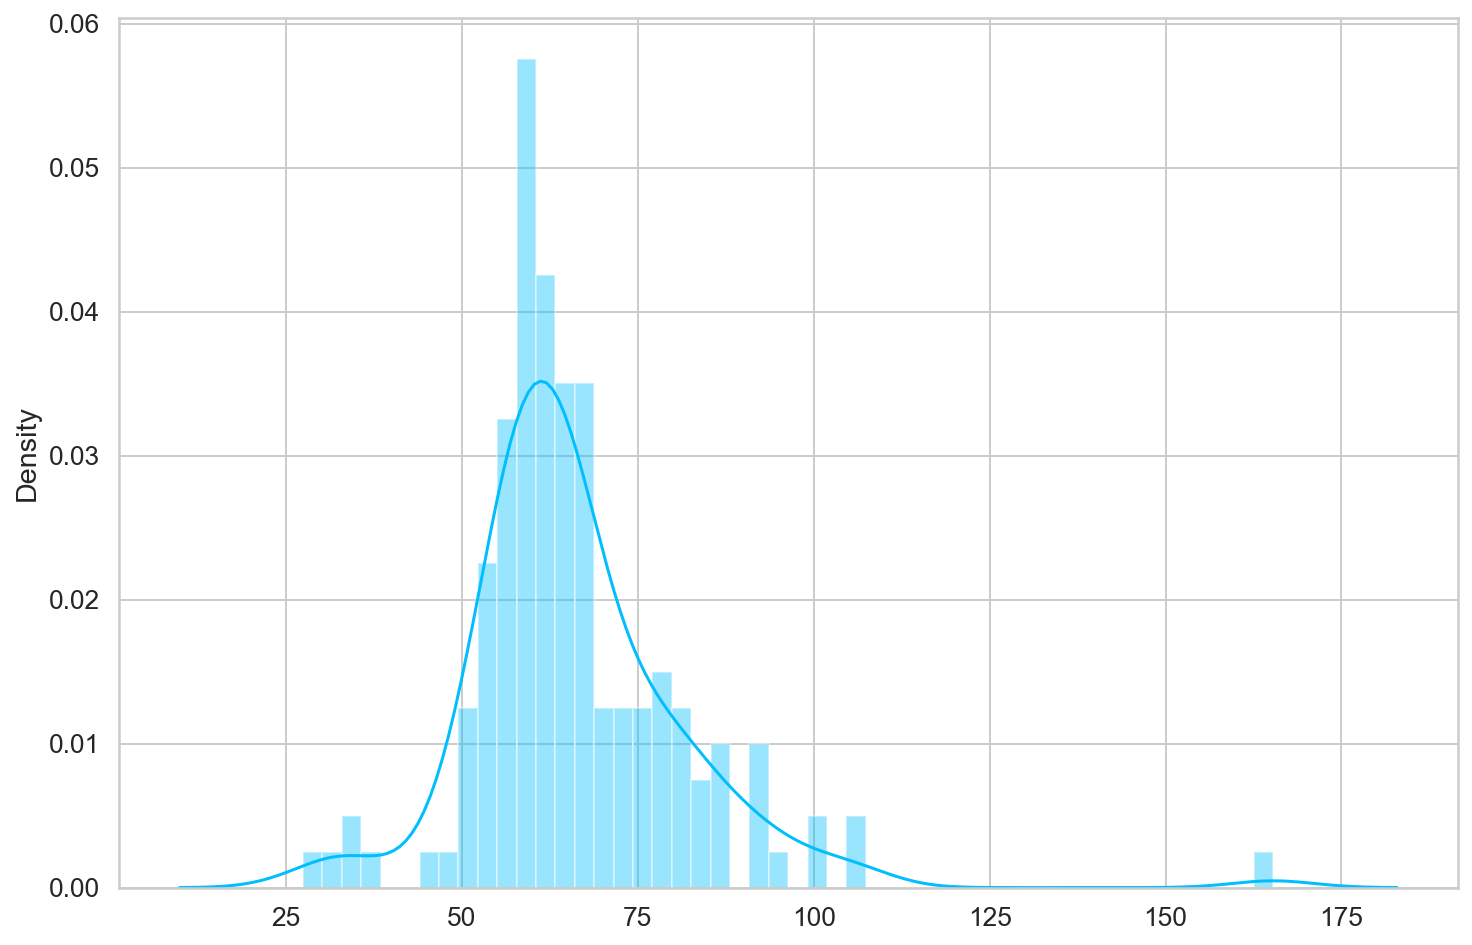

In [81]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [82]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 145/145


We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [83]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

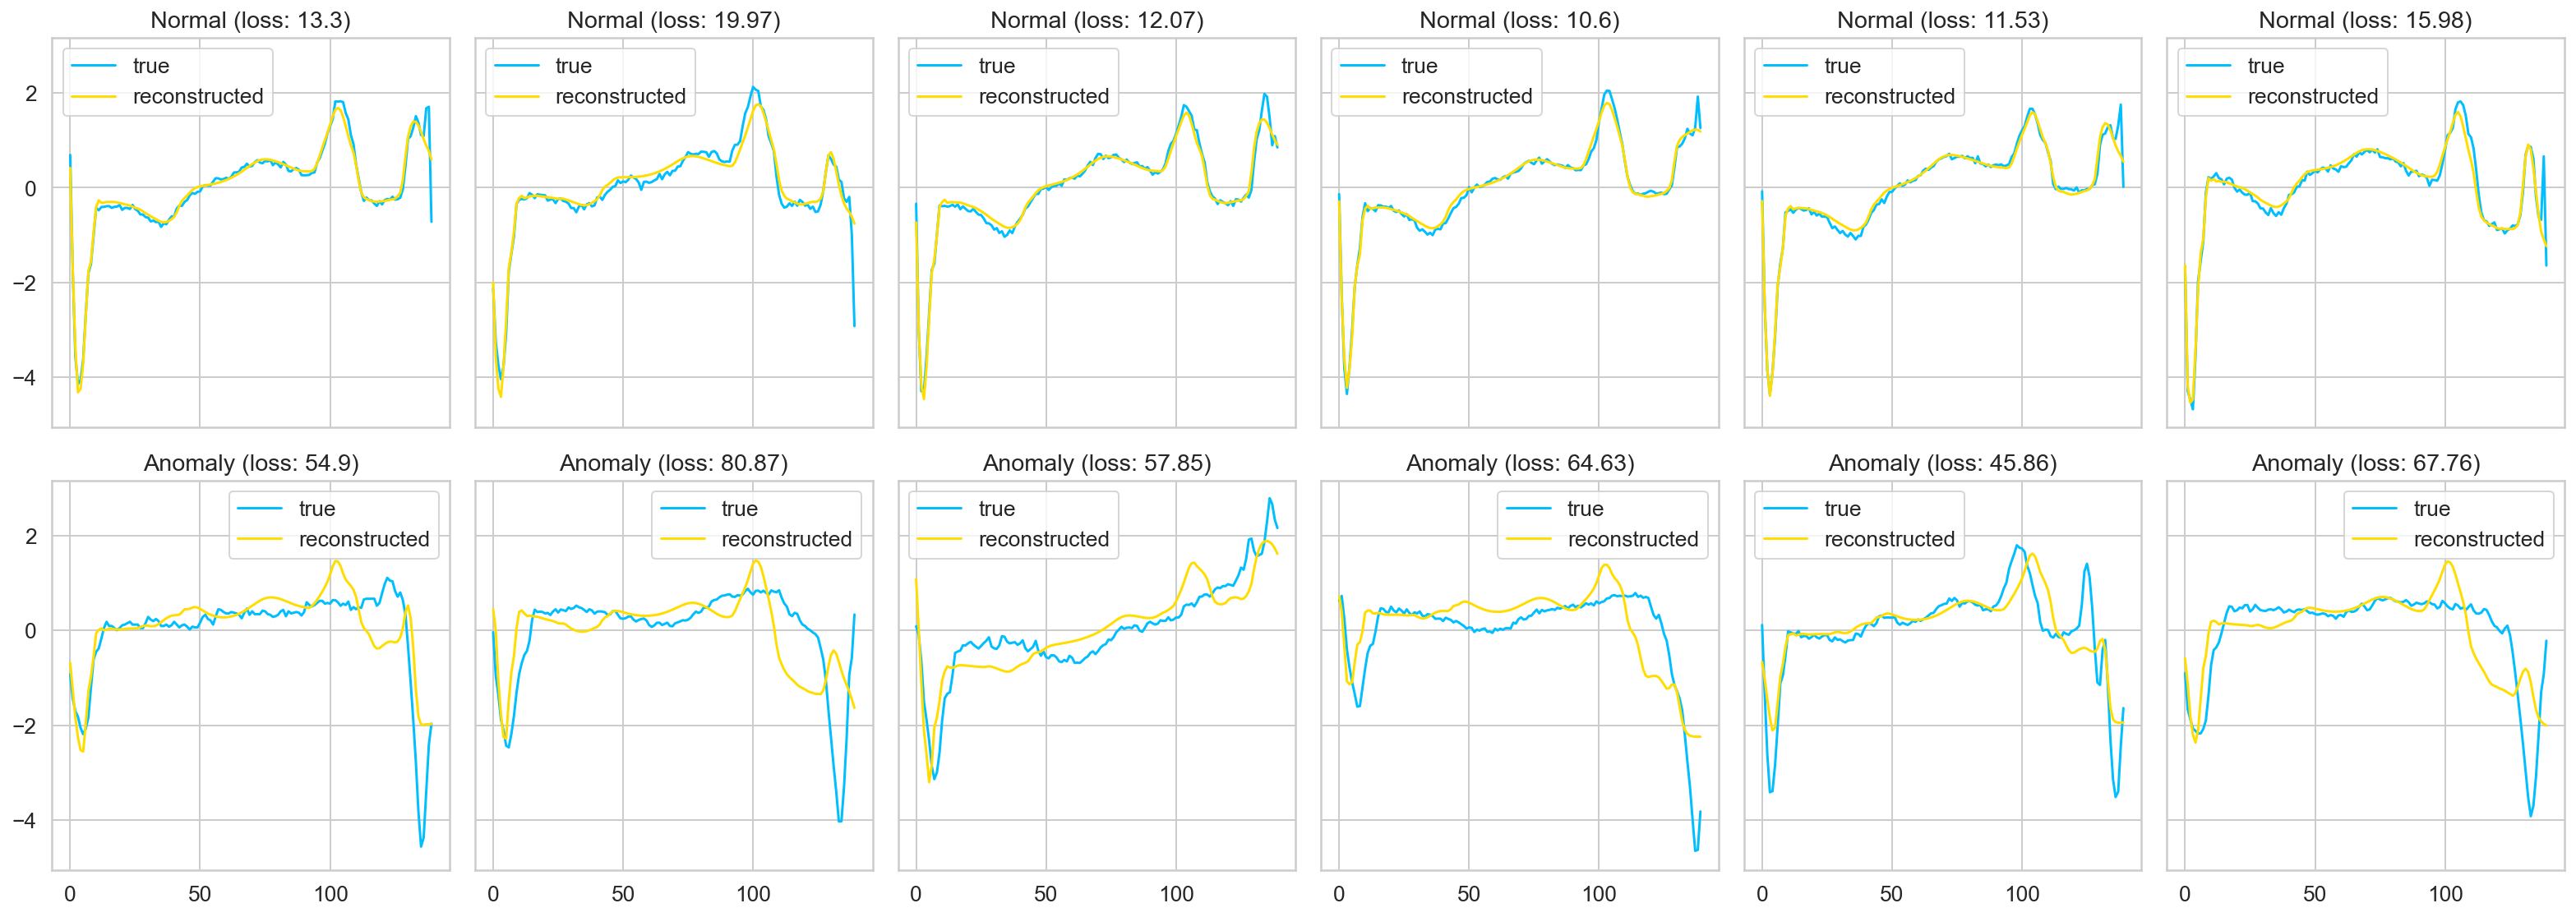

In [84]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)